En este notebook se comparan distintos modelos de regresión para predecir activaciones alineadas de la última capa de un modelo de lenguaje a partir de activaciones “faker” (no alineadas).<br>
Se realizan 3 splits distintos del dataset (60% train, 20% val, 20% test).<br>
- Para cada modelo y split se calculan RMSE y R² en validación y test.
- Se computa la media y desviación estándar de cada métrica para evaluar estabilidad y robustez.

### Cargar librerías

In [1]:
import torch
from torch.utils.data import random_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

### Cargar dataset

In [2]:
dataset = torch.load('./workspace/dataset_to_train_regressor_60_percent_neurons.pt', weights_only=False)
print(f"Dataset cargado. Número de tokens: {len(dataset)}")

Dataset cargado. Número de tokens: 110582


Análisis de diferencia máxima y mínima entre activaciones en conjuntos de validación y test:

In [3]:
X_dataset = [x for x, y, z in dataset]
Y_dataset = [y for x, y, z in dataset]

X_test_all = torch.cat(X_dataset, dim=0)
Y_test_all = torch.cat(Y_dataset, dim=0)

diff = X_test_all - Y_test_all

# Valores mínimo y máximo
diff_min = diff.min().item()
diff_max = diff.max().item()

print(f"Diferencia mínima entre activaciones alineadas y faker: {diff_min:.6f}")
print(f"Diferencia máxima entre activaciones alineadas y faker: {diff_max:.6f}")

Diferencia mínima entre activaciones alineadas y faker: -27.546875
Diferencia máxima entre activaciones alineadas y faker: 27.062500


### Cargar el modelo MLP pre-entrenado


In [4]:
import torch
import torch.nn as nn

# Definir la misma arquitectura del MLP
class SelectedNeuronsMLP(nn.Module):
    def __init__(self, n_neurons):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_neurons)
        )
    def forward(self, x):
        return self.net(x)

selected_neurons = "./workspace/selected_neurons_last_layer_p60_dict.pt"
selected_neurons = torch.load(selected_neurons, weights_only=False)

# Número de neuronas seleccionadas
n_neurons = len(selected_neurons)

# Crear el modelo e importar pesos
model_mlp = SelectedNeuronsMLP(n_neurons)
model_mlp.load_state_dict(torch.load("./workspace/mlp.pt", map_location="cuda"))
model_mlp.to("cuda")
model_mlp = model_mlp.half()

### Función para evaluar un modelo

In [5]:
def compute_metrics(Y_true, Y_pred):
    Y_true = np.array(Y_true, dtype=np.float32)
    Y_pred = np.array(Y_pred, dtype=np.float32)
    rmse = np.sqrt(((Y_true - Y_pred) ** 2).mean())
    r2   = r2_score(Y_true, Y_pred)
    return rmse, r2

### Inferencia y evaluación de modelos
1. Baseline: diferencia media entre faker y aligned (punto de partida).

2. Linear Regression: modelo lineal clásico sin regularización.

3. Lasso Regression: modelo lineal regularizado con penalización L1. --> Entrenamiento costoso

4. Ridge Regression: modelo lineal regularizado con penalización L2.

5. MLP (PyTorch): red neuronal feedforward entrenada token-a-token.

6. KNN Regressor: modelo simple basado en vecinos más cercanos.

7. SVR (Support Vector Regression): modelo no lineal que utiliza el margen de tolerancia para aproximar funciones complejas. --> Entrenamiento costoso

8. Random Forest Regressor: modelo no lineal, basado en árboles. --> Entrenamiento costoso

In [ ]:
def run_split(dataset, seed):
    torch.manual_seed(seed)

    total_len = len(dataset)
    train_len = int(0.6 * total_len)
    val_len   = int(0.2 * total_len)
    test_len  = total_len - train_len - val_len

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    X_train, Y_train, z_train = [x.cpu().numpy() for x, y, z in train_set], [y.cpu().numpy() for x, y, z in train_set], [z.cpu().numpy() for x, y, z in train_set]
    X_val,   Y_val,   z_val   = [x.cpu().numpy() for x, y, z in val_set],   [y.cpu().numpy() for x, y, z in val_set],   [z.cpu().numpy() for x, y, z in val_set]
    X_test,  Y_test,  z_test  = [x.cpu().numpy() for x, y, z in test_set],  [y.cpu().numpy() for x, y, z in test_set],  [z.cpu().numpy() for x, y, z in test_set]

    X_train, Y_train, z_train = np.stack(X_train), np.stack(Y_train), np.stack(z_train)
    X_val,   Y_val,   z_val   = np.stack(X_val),   np.stack(Y_val),   np.stack(z_val)
    X_test,  Y_test,  z_test  = np.stack(X_test),  np.stack(Y_test),  np.stack(z_test)

    results = {}

    print('Baseline')
    delta_mean = Y_train.mean(axis=0) - X_train.mean(axis=0)
    Y_pred_val = X_val + delta_mean
    Y_pred_test = X_test + delta_mean
    results["Baseline_val"]  = compute_metrics(Y_val, Y_pred_val)
    results["Baseline_test"] = compute_metrics(Y_test, Y_pred_test)

    print('Linear Regression')
    lr = LinearRegression()
    lr.fit(X_train.astype(np.float64), Y_train.astype(np.float64))
    results["Linear_val"]  = compute_metrics(Y_val, lr.predict(X_val))
    results["Linear_test"] = compute_metrics(Y_test, lr.predict(X_test))

    # print('Lasso')
    # lasso = Lasso(alpha=0.01)
    # lasso.fit(X_train, Y_train)
    # results["Lasso_val"]  = compute_metrics(Y_val, lasso.predict(X_val))
    # results["Lasso_test"] = compute_metrics(Y_test, lasso.predict(X_test))

    print('Ridge')
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train.astype(np.float64), Y_train.astype(np.float64))
    results["Ridge_val"]  = compute_metrics(Y_val, ridge.predict(X_val))
    results["Ridge_test"] = compute_metrics(Y_test, ridge.predict(X_test))

    print('MLP')
    model_mlp.eval()
    with torch.no_grad():
        X_val_tensor  = torch.tensor(X_val).cuda()
        X_test_tensor = torch.tensor(X_test).cuda()

        Y_pred_val = model_mlp(X_val_tensor).cpu().numpy()
        Y_pred_test = model_mlp(X_test_tensor).cpu().numpy()
    results["MLP_val"]  = compute_metrics(Y_val, Y_pred_val)
    results["MLP_test"] = compute_metrics(Y_test, Y_pred_test)

    print('KNN')
    knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    knn.fit(X_train, Y_train)
    results["KNN_val"]  = compute_metrics(Y_val, knn.predict(X_val))
    results["KNN_test"] = compute_metrics(Y_test, knn.predict(X_test))

    # print('SVR')
    # svr_preds_val = []
    # svr_preds_test = []
    # for i in range(Y_train.shape[1]):
    #     svr = SVR()
    #     svr.fit(X_train, Y_train[:, i])
    #     svr_preds_val.append(svr.predict(X_val))
    #     svr_preds_test.append(svr.predict(X_test))
    # results["SVR_val"]  = compute_metrics(Y_val, np.stack(svr_preds_val, axis=1))
    # results["SVR_test"] = compute_metrics(Y_test, np.stack(svr_preds_test, axis=1))
    
    # print('RandomForestRegressor')
    # rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=20)
    # rf.fit(X_train, Y_train)
    # results["RF_val"]  = compute_metrics(Y_val, rf.predict(X_val))
    # results["RF_test"] = compute_metrics(Y_test, rf.predict(X_test))

    return results

### Evaluación de modelos sobre 3 splits aleatorios del dataset

In [9]:
all_results = []
for seed in [0, 54, 223]:
    print(f"Running split with seed {seed}")
    all_results.append(run_split(dataset, seed))

# Convertir resultados a DataFrame para análisis
rows = []
for res in all_results:
    for model_key, metrics in res.items():  # metrics es una tupla (RMSE, R2)
        rmse, r2 = metrics
        rows.append({
            "Model": model_key,
            "RMSE": rmse,
            "R2": r2
        })

df = pd.DataFrame(rows)

# Media y desviación por modelo
summary = df.groupby("Model").agg(["mean", "std"])
print(summary)

                   RMSE                  R2          
                   mean       std      mean       std
Model                                                
Baseline_test  1.216578  0.001770  0.388214  0.002061
Baseline_val   1.217241  0.002021  0.387882  0.002559
KNN_test       0.771423  0.001035  0.754176  0.000622
KNN_val        0.770614  0.000430  0.754867  0.000124
Linear_test    0.672544  0.000780  0.813672  0.000472
Linear_val     0.673367  0.000364  0.813367  0.000044
MLP_test       0.685505  0.000411  0.800253  0.000224
MLP_val        0.686830  0.001199  0.799665  0.000506
Ridge_test     0.672543  0.000780  0.813673  0.000472
Ridge_val      0.673366  0.000364  0.813368  0.000044


### Visualización de resultados

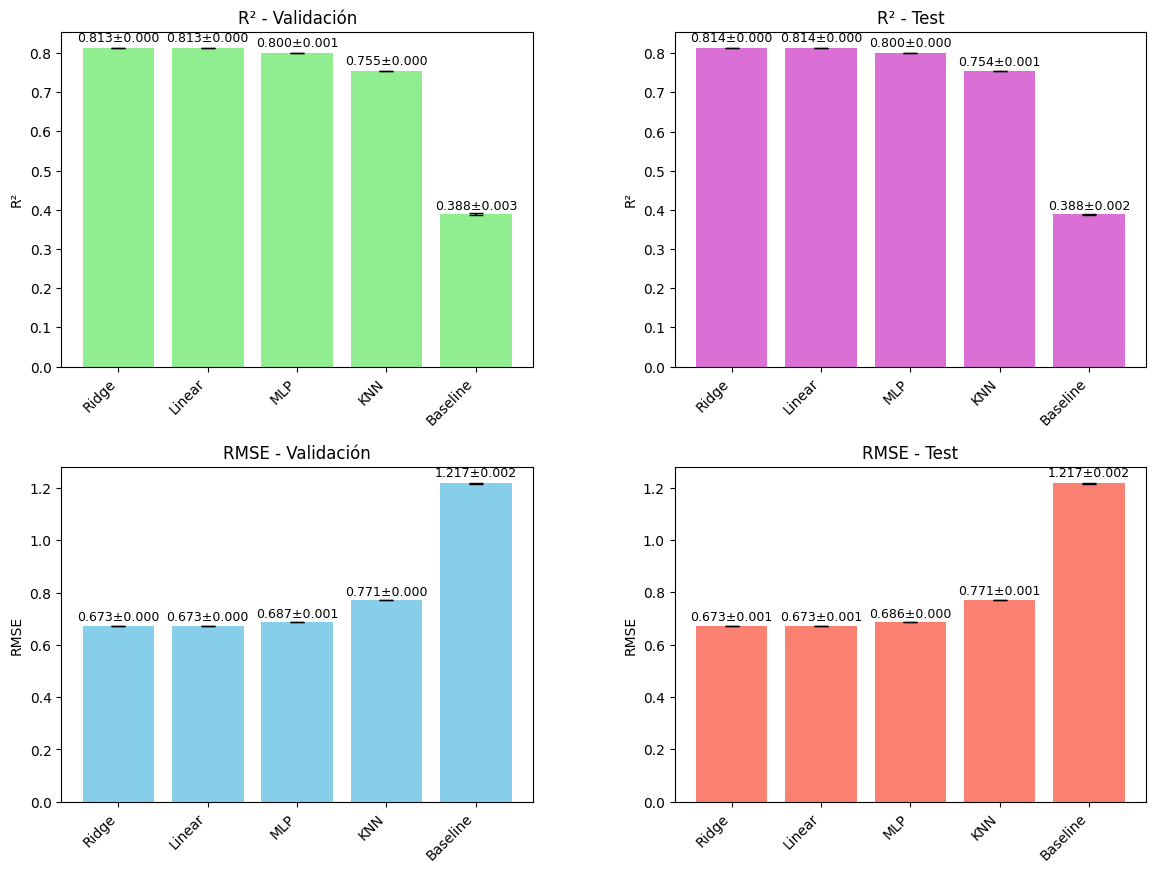

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Función para añadir valores encima de las barras
def add_values(ax, values, errors):
    for i, (v, e) in enumerate(zip(values, errors)):
        ax.text(i, v + e + 0.01*abs(v), f"{v:.3f}±{e:.3f}", ha='center', va='bottom', fontsize=9)

models = sorted(set(idx.replace('_val','').replace('_test','') for idx in summary.index))
# ------------------------
# Ordenar modelos según R² validación
# ------------------------
r2_val = summary.loc[[m+'_val' for m in models], ('R2','mean')]
r2_val_std = summary.loc[[m+'_val' for m in models], ('R2','std')]
models_sorted = r2_val.sort_values(ascending=False).index.str.replace('_val','').tolist()

# Crear subplots
fig, axes = plt.subplots(2,2, figsize=(14,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
x = np.arange(len(models_sorted))

# R² - Validación
r2_vals_sorted = r2_val[[m+'_val' for m in models_sorted]]
r2_stds_sorted = r2_val_std[[m+'_val' for m in models_sorted]]
axes[0,0].bar(x, r2_vals_sorted, yerr=r2_stds_sorted, capsize=5, color='lightgreen')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models_sorted, rotation=45, ha='right')
axes[0,0].set_title('R² - Validación')
axes[0,0].set_ylabel('R²')
add_values(axes[0,0], r2_vals_sorted, r2_stds_sorted)

# R² - Test (mismos modelos ordenados por R² validación)
r2_test = summary.loc[[m+'_test' for m in models_sorted], ('R2','mean')]
r2_test_std = summary.loc[[m+'_test' for m in models_sorted], ('R2','std')]
axes[0,1].bar(x, r2_test, yerr=r2_test_std, capsize=5, color='orchid')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(models_sorted, rotation=45, ha='right')
axes[0,1].set_title('R² - Test')
axes[0,1].set_ylabel('R²')
add_values(axes[0,1], r2_test, r2_test_std)

# RMSE - Validación (mismos modelos)
rmse_val = summary.loc[[m+'_val' for m in models_sorted], ('RMSE','mean')]
rmse_val_std = summary.loc[[m+'_val' for m in models_sorted], ('RMSE','std')]
axes[1,0].bar(x, rmse_val, yerr=rmse_val_std, capsize=5, color='skyblue')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models_sorted, rotation=45, ha='right')
axes[1,0].set_title('RMSE - Validación')
axes[1,0].set_ylabel('RMSE')
add_values(axes[1,0], rmse_val, rmse_val_std)

# RMSE - Test
rmse_test = summary.loc[[m+'_test' for m in models_sorted], ('RMSE','mean')]
rmse_test_std = summary.loc[[m+'_test' for m in models_sorted], ('RMSE','std')]
axes[1,1].bar(x, rmse_test, yerr=rmse_test_std, capsize=5, color='salmon')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models_sorted, rotation=45, ha='right')
axes[1,1].set_title('RMSE - Test')
axes[1,1].set_ylabel('RMSE')
add_values(axes[1,1], rmse_test, rmse_test_std)

plt.show()

### Exportar modelos

In [3]:
import joblib

torch.manual_seed(0)

total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len   = int(0.2 * total_len)
test_len  = total_len - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

X_train, Y_train = [x.cpu().numpy() for x, y,z in train_set], [y.cpu().numpy() for x, y,z in train_set]
X_val,   Y_val   = [x.cpu().numpy() for x, y,z in val_set],   [y.cpu().numpy() for x, y,z in val_set]
X_test,  Y_test  = [x.cpu().numpy() for x, y,z in test_set],  [y.cpu().numpy() for x, y,z in test_set]

X_train, Y_train = np.stack(X_train), np.stack(Y_train)
X_val,   Y_val   = np.stack(X_val),   np.stack(Y_val)
X_test,  Y_test  = np.stack(X_test),  np.stack(Y_test)

In [4]:
# Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train.astype(np.float64), Y_train.astype(np.float64))
joblib.dump(linear_model, "./workspace/models/linear_model.pkl")
print("Modelo guardado en ./workspace/models/linear_model.pkl")

Modelo guardado en ./workspace/models/linear_model.pkl


In [5]:
# Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train.astype(np.float64), Y_train.astype(np.float64))
joblib.dump(ridge_model, "./workspace/models/ridge_model.pkl")
print("Modelo guardado en ./workspace/models/ridge_model.pkl")

Modelo guardado en ./workspace/models/ridge_model.pkl


In [6]:
# KNN
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, Y_train)
joblib.dump(knn_model, "./workspace/models/knn_model.pkl")
print("Modelo guardado en ./workspace/models/knn_model.pkl")

Modelo guardado en ./workspace/models/knn_model.pkl
